In [1]:
import re
import pandas as pd
import seaborn as sns
import numpy as np
import spacy
import unicodedata
import en_core_web_sm
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt  
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, auc, roc_curve, precision_recall_curve
from textblob import TextBlob
import random
#from pandas_profiling import ProfileReport   
#pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [2]:
df=pd.read_csv('C:/Users/anagha.bhople/Desktop/Sentiment Analysis/Womens Clothing E-Commerce Reviews.csv')

# Data Cleaning

In [3]:
df.drop(['Age','Clothing ID', 'Division Name', 'Department Name', 'Class Name'], axis = 1, inplace=True)
df.reset_index(inplace=True)
df.drop(['Unnamed: 0'],axis = 1, inplace=True)
df.set_index('index')
index_names = df[df['Review Text'].isnull() & df['Title'].isnull()].index 
df.drop(index_names, inplace = True) 
df[df['Review Text'].isnull() & df['Title'].isnull()].sum(axis=0)
df['Review Text'].isnull().sum(axis = 0)
idx=df[df['Review Text'].isnull()].index
df['Title'].isnull().sum(axis = 0)
df['Review Text'][idx]
df['Title'][idx]
df['Review Text'][idx]=df['Title'][idx]
df['Review Text'][idx]
df.drop(['Title'],axis = 1, inplace=True)

<ipython-input-3-f02947f230e3>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Review Text'][idx]=df['Title'][idx]
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


# Text Preprocessing

In [4]:
def strip_accents(text):

    try:
        text = unicode(text, 'utf-8')
    except NameError: # unicode is a default on python 3 
        pass

    text = unicodedata.normalize('NFD', text)\
           .encode('ascii', 'ignore')\
           .decode("utf-8")
    

    return str(text)

df['Review Text Precrocessed']=df['Review Text'].apply(lambda x: strip_accents(x))

# def spell_check(x):
#     x=TextBlob(str(x)).correct()
#     return ''.join(x)

# df['Review Text Precrocessed']=df['Review Text Precrocessed'].apply(lambda x: spell_check(x))


def char_count(x):
    s=x.split()
    s=str(s)
    x=' '.join(s)
    return len(x)

df['Char_Count']=df['Review Text Precrocessed'].apply(lambda x: char_count(x.encode('utf-8')))


def word_count(x):
    return len(str(x).split())

df['Word_Count']=df['Review Text Precrocessed'].apply(lambda x: word_count(x.encode('utf-8')))

def remove_sapce(x):
    x=' '.join(x.split())
    return x
df['Review Text Precrocessed']=df['Review Text Precrocessed'].apply(lambda x: remove_sapce(x))

df['Review Text Precrocessed']=df['Review Text Precrocessed'].str.lower()

contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"i'm": "i am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

for key, value in contractions.items():
  key= key.lower()
  value=value.lower()
  
def cont_to_exp(x):
    if type(x) is str:
        for key in contractions:
            value=contractions[key]
            x=x.replace(key,value)
        return x
    return x
df['Review Text Precrocessed']=df['Review Text Precrocessed'].apply(lambda x: cont_to_exp(x))


def puntuation_removal(x):
    x=re.sub(r'[^\w]+', " ", x)
    return x

df['Review Text Precrocessed']=df['Review Text Precrocessed'].apply(lambda x: puntuation_removal(str(x)))

In [5]:
df.head(10)

,index,Review Text,Rating,Recommended IND,Positive Feedback Count,Review Text Precrocessed,Char_Count,Word_Count
0,0,Absolutely wonderful - silky and sexy and comf...,4,1,0,absolutely wonderful silky and sexy and comfor...,171,8
1,1,Love this dress! it's sooo pretty. i happene...,5,1,4,love this dress it is sooo pretty i happened t...,1095,62
2,2,I had such high hopes for this dress and reall...,3,0,0,i had such high hopes for this dress and reall...,1785,98
3,3,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,i love love love this jumpsuit it is fun flirt...,425,22
4,4,This shirt is very flattering to all due to th...,5,1,6,this shirt is very flattering to all due to th...,673,36
5,5,"I love tracy reese dresses, but this one is no...",2,0,4,i love tracy reese dresses but this one is not...,1761,98
6,6,I aded this in my basket at hte last mintue to...,5,1,1,i aded this in my basket at hte last mintue to...,1801,101
7,7,"I ordered this in carbon for store pick up, an...",4,1,4,i ordered this in carbon for store pick up and...,1741,97
8,8,I love this dress. i usually get an xs but it ...,5,1,0,i love this dress i usually get an xs but it r...,605,34
9,9,"I'm 5""5' and 125 lbs. i ordered the s petite t...",5,1,0,i am 5 5 and 125 lbs i ordered the s petite to...,1299,72


In [ ]:
df['Review Text Precrocessed']

# Tokennization

In [6]:
def tokenize(x):
    x= TextBlob(str(x)).words
    return x
# df['Review Text Precrocessed']=df['Review Text Precrocessed'].apply(lambda x: tokenize(x))

# Lemmatization

In [7]:
nlp = spacy.load('en_core_web_sm')
def make_to_base(x):
    x_list=[]
    doc=nlp(x)
    for token in doc:
        lemma=token.lemma_
        
        if lemma=='_PRON_' or lemma == 'be' or lemma == 'is': 
            lemma=token.text
            
        
        x_list.append(lemma)
    return ' '.join(x_list)

df['Review Text Precrocessed']=df['Review Text Precrocessed'].apply(lambda x: make_to_base(x))

In [ ]:
df.head(10)

# Label Generation

In [7]:
def la(x):
    if(x>3):
        return 1
    else:
        return 0
    
df['Label']=df['Rating'].apply(lambda x:la(x))
Positive_review_1=[]
Negative_review_1=[]
Positive_review_1=df[df['Label']==1]
Negative_review_1=df[df['Label']==0]


In [8]:
def label(x):
    if(x>3):
        return 1
    elif(x==3):
        return 2
    else:
        return 0

df['Label_3C']=df['Rating'].apply(lambda x:label(x))
Positive_review=[]
Negative_review=[]
Neutral_review=[]
Positive_review=df[df['Label_3C']==1]
Negative_review=df[df['Label_3C']==0]
Neutral_review=df[df['Label_3C']==2]


# TFIDF Vector Generation

In [9]:
stopwords = ['a', 'about', 'an', 'and', 'are', 'as', 'at', 'be', 'been', 'but', 'by', 'can', \
             'even', 'ever', 'for', 'from', 'get', 'had', 'has', 'have', 'he', 'her', 'hers', 'his', \
             'how', 'i', 'if', 'in', 'into', 'is', 'it', 'its', 'just', 'me', 'my', 'of', 'on', 'or', \
             'see', 'seen', 'she', 'so', 'than', 'that', 'the', 'their', 'there', 'they', 'this', \
             'to', 'was', 'we', 'were', 'what', 'when', 'which', 'who', 'will', 'with', 'you','-PRON-']


from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer(stop_words=stopwords, tokenizer= tokenize, ngram_range=(1, 2), max_df=0.9, min_df=3, sublinear_tf=True)

X=tfidf.fit_transform(df['Review Text Precrocessed'])
X.shape

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['pron'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


(22642, 51918)

In [ ]:
import sys
!{sys.executable} -m textblob.download_corpora --user

In [11]:
yes=pd.DataFrame(X.toarray(), columns=tfidf.get_feature_names())
yes.shape

(22642, 51918)

# Splitting Data

In [33]:
y=df['Label']
X=X
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=.20,random_state=0)

In [ ]:
#y_test

# ROC and Confusion Matrix

In [10]:
def get_ROC(y_test, y_pred):
    
    # Compute ROC and plot curve
    
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred)
    roc_auc_rf = auc(fpr_rf, tpr_rf)
    #plt.figure(figsize=(8,8))
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.plot(fpr_rf, tpr_rf, lw=1, label='{} curve (AUC = {:0.2f})'.format('RF',roc_auc_rf))
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC curve', fontsize=16)
    plt.legend(loc='lower right', fontsize=13)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.axes().set_aspect('equal')
    plt.show()
    
def get_ROC_multiclass(y_test, y_pred):
    
    #Compute ROC and plot curve for three classes
    
    n_classes=3
    # roc curve
    fpr = dict()
    tpr = dict()
    aucroc=dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i],
                                  y_pred[:, i])
        aucroc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2, label='class {} (AUC = {:0.2f})'.format(i, aucroc[i] ))

    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    plt.legend(loc="best")
    plt.title("ROC curve")
    plt.show()


def get_Precision_Recall(y_test, y_pred):
    
    # Compute Precision-Recall and plot curve
    
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
    area = auc(recall, precision)
    print("Area Under Curve: %0.2f" % area)
    plt.clf()
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall example: AUC=%0.2f' % area)
    plt.legend(loc="lower left")
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.axes().set_aspect('equal')
    plt.show()
    
    
def get_Precision_Recall_multiclass(y_test, y_pred):
    
    precision = dict()
    recall = dict()
    area=dict()
    n_classes=3
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_pred[:, i])
        area[i] = auc(precision[i], recall[i])
        plt.plot(recall[i], precision[i], lw=2, label='class {} (AUC = {:0.2f})'.format(i, area[i]))
        

    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend(loc="best")
    plt.title("precision vs. recall curve")
    plt.show()
        
    
def get_Confusion_Matrix(y_test, y_pred):
    
    # Compute and plot Confusion Matrix 
    
    mat = confusion_matrix(y_test, y_pred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
        xticklabels='auto', yticklabels='auto')
    plt.xlabel('true label')
    plt.ylabel('predicted label');
    plt.show()
    

# Random Forest

## Binary Classification

In [12]:
def RandomForestBinaryClassifier(X_train, y_train, X_test, y_test):
    
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    Confusion_matrix = confusion_matrix(y_test, y_pred)
    Classification_report = classification_report(y_test, y_pred)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    Accuracy_score = accuracy_score(y_test, y_pred)
    print('Accuracy Score: {}'.format(Accuracy_score))
    F1_score = f1_score(y_test, y_pred)
    print('F1 Score: {}'.format(F1_score))
    Average_precision = average_precision_score(y_test, y_pred)
    print('Average precision-recall score: {}'.format(Average_precision))
    get_Confusion_Matrix(y_test, y_pred)
    get_Precision_Recall(y_test, y_pred)
    get_ROC(y_test, y_pred)
    return Confusion_matrix, Classification_report

#RandomForestBinaryClassifier(X_train, y_train, X_test, y_test)

# Binary Classification with Hyperparameter Tuning

In [ ]:
def RandomForestBinaryClassifierTuned(X_train, y_train, X_test, y_test, max_features):
    clf = RandomForestClassifier(min_samples_leaf = 1, n_estimators =25, min_samples_split =8, criterion= 'gini', max_features=max_features, max_depth= 40)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    Confusion_matrix = confusion_matrix(y_test, y_pred)
    Classification_report = classification_report(y_test, y_pred)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    Accuracy_score = accuracy_score(y_test, y_pred)
    print('Accuracy Score: {}'.format(Accuracy_score))
    F1_score = f1_score(y_test, y_pred)
    print('F1 Score: {}'.format(F1_score))
    Average_precision = average_precision_score(y_test, y_pred)
    print('Average precision-recall score: {}'.format(Average_precision))
    get_Confusion_Matrix(y_test, y_pred)
    get_Precision_Recall(y_test, y_pred)
    get_ROC(y_test, y_pred)
    return Confusion_matrix, Classification_report
    
RandomForestBinaryClassifierTuned(X_train, y_train, X_test, y_test, 25000)

# SVM

## SVM for Binary Classification 

In [ ]:
def svm_binary_classification(X_train, y_train, X_test, y_test):
    clf_svm=SVC()
    clf_svm.fit(X_train, y_train)
    pre=clf_svm.predict(X_test)
    Confusion_matrix = confusion_matrix(y_test, pre)
    Classification_report = classification_report(y_test, pre)
    print(confusion_matrix(y_test,pre))
    print(classification_report(y_test, pre))
    Accuracy_score = accuracy_score(y_test, pre)
    print('Accuracy Score: {}'.format(Accuracy_score))
    F1_score = f1_score(y_test, pre)
    print('F1 Score: {}'.format(F1_score))
    Average_precision = average_precision_score(y_test, pre)
    print('Average precision-recall score: {}'.format(Average_precision))
    get_Confusion_Matrix(y_test, pre)
    get_Precision_Recall(y_test, pre)
    get_ROC(y_test, pre)
    return Confusion_matrix, Classification_report

svm_binary_classification(X_train, y_train, X_test, y_test)

## SVM for Binary Classification with Hyperparameter Tuning

In [ ]:
def svm_binary_classification_tuned(X_train, y_train, X_test, y_test):
    clf_svm=SVC(C=1.5, gamma=1, kernel='rbf')
    clf_svm.fit(X_train, y_train)
    pre=clf_svm.predict(X_test)
    Confusion_matrix = confusion_matrix(y_test, pre)
    Classification_report = classification_report(y_test, pre)
    print(confusion_matrix(y_test,pre))
    print(classification_report(y_test, pre))
    Accuracy_score = accuracy_score(y_test, pre)
    print('Accuracy Score: {}'.format(Accuracy_score))
    F1_score = f1_score(y_test, pre)
    print('F1 Score: {}'.format(F1_score))
    Average_precision = average_precision_score(y_test, pre)
    print('Average precision-recall score: {}'.format(Average_precision))
    get_Confusion_Matrix(y_test, pre)
    get_Precision_Recall(y_test, pre)
    get_ROC(y_test, pre)
    return Confusion_matrix, Classification_report

svm_binary_classification_tuned(X_train, y_train, X_test, y_test)

# Logistic Regression

## Logistic Regression for Binary Classification

In [13]:
def LogisticRegression_binary_classification(X_train, y_train, X_test, y_test):
    logisticRegr = LogisticRegression()
    logisticRegr.fit(X_train, y_train)
    predictions = logisticRegr.predict(X_test)
    Confusion_matrix = confusion_matrix(y_test, predictions)
    Classification_report = classification_report(y_test, predictions)
    print(confusion_matrix(y_test,predictions))
    print(classification_report(y_test, predictions))
    Accuracy_score = accuracy_score(y_test, predictions)
    print('Accuracy Score: {}'.format(Accuracy_score))
    F1_score = f1_score(y_test, predictions)
    print('F1 Score: {}'.format(F1_score))
    Average_precision = average_precision_score(y_test, predictions)
    print('Average precision-recall score: {}'.format(Average_precision))
    get_Confusion_Matrix(y_test, predictions)
    get_Precision_Recall(y_test, predictions)
    get_ROC(y_test, predictions)
    return Confusion_matrix, Classification_report

#LogisticRegression_binary_classification(X_train, y_train, X_test, y_test)

## Logistic Regression for Binary Classification with Hyperparameter Tuning

In [ ]:
def LogisticRegression_binary_classification_Tuned(X_train, y_train, X_test, y_test):
    logisticRegr = LogisticRegression()
    logisticRegr.fit(X_train, y_train)
    predictions = logisticRegr.predict(X_test)
    Confusion_matrix = confusion_matrix(y_test, predictions)
    Classification_report = classification_report(y_test, predictions)
    print(confusion_matrix(y_test,predictions))
    print(classification_report(y_test, predictions))
    Accuracy_score = accuracy_score(y_test, predictions)
    print('Accuracy Score: {}'.format(Accuracy_score))
    F1_score = f1_score(y_test, predictions)
    print('F1 Score: {}'.format(F1_score))
    Average_precision = average_precision_score(y_test, predictions)
    print('Average precision-recall score: {}'.format(Average_precision))
    get_Confusion_Matrix(y_test, predictions)
    get_Precision_Recall(y_test, predictions)
    get_ROC(y_test, predictions)
    return Confusion_matrix, Classification_report

LogisticRegression_binary_classification_Tuned(X_train, y_train, X_test, y_test)

# Naive Bayes

## Naive Bayes for Binary Classification

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB  

def NaiveBayes_binary_classification_Tuned(X_train, y_train, X_test, y_test):
    model = MultinomialNB()  
    nv = model.fit(X_train.toarray(), y_train)
    predictions=nv.predict(X_test.toarray())
    Confusion_matrix = confusion_matrix(y_test, predictions)
    Classification_report = classification_report(y_test, predictions)
    print(confusion_matrix(y_test,predictions))
    print(classification_report(y_test, predictions))
    Accuracy_score = accuracy_score(y_test, predictions)
    print('Accuracy Score: {}'.format(Accuracy_score))
    F1_score = f1_score(y_test, predictions)
    print('F1 Score: {}'.format(F1_score))
    Average_precision = average_precision_score(y_test, predictions)
    print('Average precision-recall score: {}'.format(Average_precision))
    get_Confusion_Matrix(y_test, predictions)
    get_Precision_Recall(y_test, predictions)
    get_ROC(y_test, predictions)
    return Confusion_matrix, Classification_report

NaiveBayes_binary_classification_Tuned(X_train, y_train, X_test, y_test)

## Naive Bayes for Binary Classification with Hyperparameter Tuning

# Decision Tree

## Decision Tree for Binary Classification

In [ ]:
from sklearn.tree import DecisionTreeClassifier
def Decision_Tree_binary_classification_Tuned(X_train, y_train, X_test, y_test):
    dtc = DecisionTreeClassifier(random_state=0)
    dtc.fit(X_train, y_train)
    predictions = dtc.predict(X_test)
    Confusion_matrix = confusion_matrix(y_test, predictions)
    Classification_report = classification_report(y_test, predictions)
    print(confusion_matrix(y_test,predictions))
    print(classification_report(y_test, predictions))
    Accuracy_score = accuracy_score(y_test, predictions)
    print('Accuracy Score: {}'.format(Accuracy_score))
    F1_score = f1_score(y_test, predictions)
    print('F1 Score: {}'.format(F1_score))
    Average_precision = average_precision_score(y_test, predictions)
    print('Average precision-recall score: {}'.format(Average_precision))
    get_Confusion_Matrix(y_test, predictions)
    get_Precision_Recall(y_test, predictions)
    get_ROC(y_test, predictions)
    return Confusion_matrix, Classification_report

Decision_Tree_binary_classification_Tuned(X_train, y_train, X_test, y_test)

## Decision Tree for Binary Classification with Hyperparameter Tuning

## XGBoost

## XGBoost for Binary Classification

In [ ]:
from xgboost import XGBClassifier
def XgBoost_binary_classification_Tuned(X_train, y_train, X_test, y_test):
    xgb = XGBClassifier()
    xgb.fit(X_train, y_train)
    predictions = xgb.predict(X_test)
    Confusion_matrix = confusion_matrix(y_test, predictions)
    Classification_report = classification_report(y_test, predictions)
    print(confusion_matrix(y_test,predictions))
    
    print(classification_report(y_test, predictions))
    Accuracy_score = accuracy_score(y_test, predictions)
    print('Accuracy Score: {}'.format(Accuracy_score))
    F1_score = f1_score(y_test, predictions)
    print('F1 Score: {}'.format(F1_score))
    Average_precision = average_precision_score(y_test, predictions)
    print('Average precision-recall score: {}'.format(Average_precision))
    get_Confusion_Matrix(y_test, predictions)
    get_Precision_Recall(y_test, predictions)
    get_ROC(y_test, predictions)
    return Confusion_matrix, Classification_report

XgBoost_binary_classification_Tuned(X_train, y_train, X_test, y_test)

# Word2Vec

## Using Spacy

In [ ]:
import sys
!{sys.executable} -m spacy download en_core_web_lg

In [25]:
import en_core_web_lg
nlp1 = en_core_web_lg.load()

In [26]:
def get_vec(x):
    doc=nlp1(x)
    vec=doc.vector
    return vec

In [27]:
df['Review Vector']=df['Review Text Precrocessed'].apply(lambda x: get_vec(x))

In [28]:
df.head()

,index,Review Text,Rating,Recommended IND,Positive Feedback Count,Review Text Precrocessed,Char_Count,Word_Count,Label,Label_3C,Review Text w2v,doc_vector,Review Vector
0,0,Absolutely wonderful - silky and sexy and comf...,4,1,0,absolutely wonderful silky and sexy and comfor...,171,8,1,1,"[absolutely, wonderful, silky, and, sexy, and,...","[0.6038291, 0.19605957, 0.7809154, 0.8917468, ...","[0.05038286, 0.040566426, -0.26723757, 0.09293..."
1,1,Love this dress! it's sooo pretty. i happene...,5,1,4,love this dress -PRON- is sooo pretty i happen...,1095,62,1,1,"[love, this, dress, PRON, is, sooo, pretty, i,...","[0.18071634, -0.33589283, -0.1262703, -0.39025...","[-0.055735458, 0.24579218, -0.25002825, -0.012..."
2,2,I had such high hopes for this dress and reall...,3,0,0,i have such high hope for this dress and reall...,1785,98,0,2,"[i, have, such, high, hope, for, this, dress, ...","[0.109867126, -0.016870249, -0.7181431, -0.323...","[-0.025143184, 0.120843865, -0.17390709, 0.033..."
3,3,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,i love love love this jumpsuit -PRON- is fun f...,425,22,1,1,"[i, love, love, love, this, jumpsuit, PRON, is...","[-0.026588626, 0.17082708, 0.08065285, -0.2498...","[0.027886605, 0.20771609, -0.1784711, -0.13507..."
4,4,This shirt is very flattering to all due to th...,5,1,6,this shirt is very flattering to all due to th...,673,36,1,1,"[this, shirt, is, very, flattering, to, all, d...","[-0.13901894, -0.36747223, 0.68351287, 0.12014...","[0.059171822, 0.113866895, -0.1971494, 0.08237..."


In [29]:
df['Review Vector'].shape

(22642,)

In [30]:
word2vec = np.array(df['Review Vector'])

In [31]:
word2vec.shape

(22642,)

In [32]:
word2vec = word2vec.reshape(-1,1)

In [33]:
word2vec.shape

(22642, 1)

In [34]:
word2vec = np.concatenate(np.concatenate(word2vec, axis = 0), axis = 0).reshape(-1, 300)
word2vec.shape

(22642, 300)

In [35]:
w2v_Y=df['Label']
w2v_X=word2vec
w2vX_train, w2vX_test, w2vy_train, w2vy_test = train_test_split(w2v_X,w2v_Y, test_size=.20, random_state=101)

[[ 263  768]
 [  79 3419]]
              precision    recall  f1-score   support

           0       0.77      0.26      0.38      1031
           1       0.82      0.98      0.89      3498

    accuracy                           0.81      4529
   macro avg       0.79      0.62      0.64      4529
weighted avg       0.81      0.81      0.77      4529

Accuracy Score: 0.8129829984544049
F1 Score: 0.8897852960312297
Average precision-recall score: 0.8155764526076615


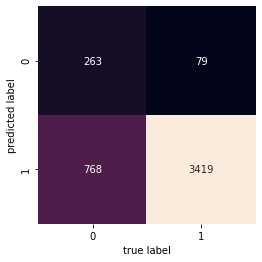

Area Under Curve: 0.91


<ipython-input-10-d3da9126ecf1>:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


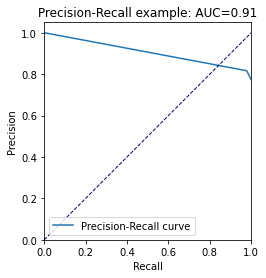

<ipython-input-10-d3da9126ecf1>:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


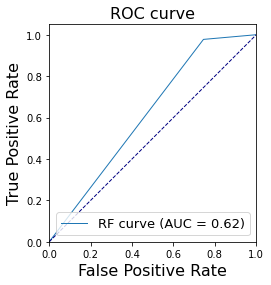

(array([[ 263,  768],
        [  79, 3419]], dtype=int64),
 '              precision    recall  f1-score   support\n\n           0       0.77      0.26      0.38      1031\n           1       0.82      0.98      0.89      3498\n\n    accuracy                           0.81      4529\n   macro avg       0.79      0.62      0.64      4529\nweighted avg       0.81      0.81      0.77      4529\n')

In [36]:
RandomForestBinaryClassifier(w2vX_train, w2vy_train, w2vX_test, w2vy_test)

In [ ]:
RandomForestBinaryClassifierTuned(w2vX_train, w2vy_train, w2vX_test, w2vy_test, 300)

In [37]:
svm_binary_classification(w2vX_train, w2vy_train, w2vX_test, w2vy_test)

NameError: name 'svm_binary_classification' is not defined

In [ ]:
svm_binary_classification_tuned(w2vX_train, w2vy_train, w2vX_test, w2vy_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[ 565  466]
 [ 169 3329]]
              precision    recall  f1-score   support

           0       0.77      0.55      0.64      1031
           1       0.88      0.95      0.91      3498

    accuracy                           0.86      4529
   macro avg       0.82      0.75      0.78      4529
weighted avg       0.85      0.86      0.85      4529

Accuracy Score: 0.8597924486641643
F1 Score: 0.9129302070478541
Average precision-recall score: 0.8721411547421507


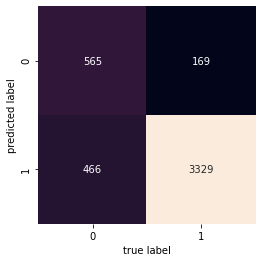

Area Under Curve: 0.93


<ipython-input-10-d3da9126ecf1>:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


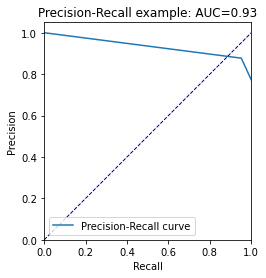

<ipython-input-10-d3da9126ecf1>:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


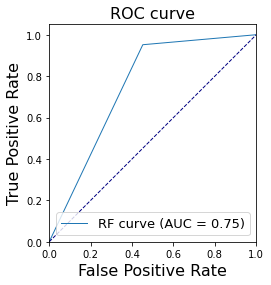

(array([[ 565,  466],
        [ 169, 3329]], dtype=int64),
 '              precision    recall  f1-score   support\n\n           0       0.77      0.55      0.64      1031\n           1       0.88      0.95      0.91      3498\n\n    accuracy                           0.86      4529\n   macro avg       0.82      0.75      0.78      4529\nweighted avg       0.85      0.86      0.85      4529\n')

In [38]:
LogisticRegression_binary_classification(w2vX_train, w2vy_train, w2vX_test, w2vy_test)

In [ ]:
LogisticRegression_binary_classification_Tuned(w2vX_train, w2vy_train, w2vX_test, w2vy_test)

In [1]:
NaiveBayes_binary_classification_Tuned(w2vX_train, w2vy_train, w2vX_test, w2vy_test)

NameError: name 'NaiveBayes_binary_classification_Tuned' is not defined

In [ ]:
Decision_Tree_binary_classification_Tuned(w2vX_train, w2vy_train, w2vX_test, w2vy_test)

In [ ]:
XgBoost_binary_classification_Tuned(w2vX_train, w2vy_train, w2vX_test, w2vy_test)

## Using Gensim

In [ ]:
## https://www.guru99.com/word-embedding-word2vec.html
## https://medium.com/swlh/sentiment-classification-using-word-embeddings-word2vec-aedf28fbb8ca
## https://www.geeksforgeeks.org/python-word-embedding-using-word2vec/
## https://www.kaggle.com/sahib12/document-embedding-techniques

In [12]:
import gensim
from gensim.models import Word2Vec

In [13]:
def tokenize(x):
    x= TextBlob(str(x)).words
    return x
df['Review Text w2v']=df['Review Text Precrocessed'].apply(lambda x: tokenize(x))

In [14]:
df['Review Text w2v'].iloc[0]

WordList(['absolutely', 'wonderful', 'silky', 'and', 'sexy', 'and', 'comfortable'])

In [15]:
#pip install gensim --user

In [17]:
model = Word2Vec(df['Review Text w2v'], size=10, window=50, min_count=30, workers=10, sg=0, iter=200)

In [1]:
model

NameError: name 'model' is not defined

In [ ]:
def document_vector(doc):
    """Create document vectors by averaging word vectors. Remove out-of-vocabulary words."""
    doc = [word for word in doc if word in model.wv.vocab]
    return np.mean(model[doc], axis=0)


df['doc_vector'] = df['Review Text w2v'].apply(document_vector)
#test['doc_vector'] = df['Review Text w2v'].apply(document_vector)


In [20]:
df['doc_vector'].iloc[0]

array([ 6.03829086e-01,  1.96059570e-01,  7.80915380e-01,  8.91746819e-01,
        9.69782829e-01,  1.75955021e+00, -1.67067063e+00,  1.20490432e-01,
        5.40522635e-01, -1.05649316e+00,  1.17294721e-01,  1.34982258e-01,
       -4.18544769e-01, -4.24237937e-01, -9.92986023e-01, -4.71443385e-01,
        1.27692854e+00, -1.20579457e+00,  1.21590638e+00, -7.13016987e-01,
        3.57487112e-01, -6.01819038e-01, -6.86291039e-01, -5.56152761e-01,
       -1.19293487e+00, -2.01236829e-01,  8.25563133e-01, -1.40333045e+00,
        3.53127003e-01,  2.06574291e-01, -8.28815341e-01,  5.44629157e-01,
       -2.69929737e-01,  1.62477767e+00,  1.10599980e-01,  1.06797583e-01,
       -5.24778306e-01, -4.44484532e-01,  4.06017035e-01, -1.41583812e+00,
        1.11938977e+00,  1.77339768e+00,  1.41726628e-01,  1.75510681e+00,
        1.34429061e+00,  1.62920082e+00,  1.20786071e+00, -9.61580455e-01,
       -8.46450686e-01,  8.07452559e-01, -5.95734239e-01, -3.36376667e-01,
        3.06574911e-01, -

In [ ]:
X = list(df['doc_vector']).shape

In [22]:
w2v_Y=df['Label']
w2v_X=X
w2vX_train, w2vX_test, w2vy_train, w2vy_test = train_test_split(w2v_X,w2v_Y, test_size=.20, random_state=101)

[[ 457  574]
 [ 115 3383]]
              precision    recall  f1-score   support

           0       0.80      0.44      0.57      1031
           1       0.85      0.97      0.91      3498

    accuracy                           0.85      4529
   macro avg       0.83      0.71      0.74      4529
weighted avg       0.84      0.85      0.83      4529

Accuracy Score: 0.8478692868182822
F1 Score: 0.9075788061703556
Average precision-recall score: 0.8522255633874495


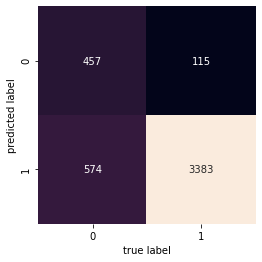

Area Under Curve: 0.92


<ipython-input-10-d3da9126ecf1>:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


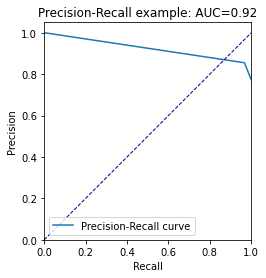

<ipython-input-10-d3da9126ecf1>:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


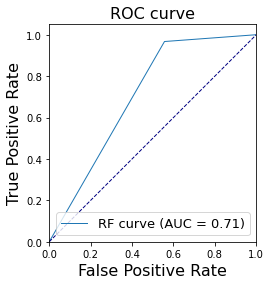

(array([[ 457,  574],
        [ 115, 3383]], dtype=int64),
 '              precision    recall  f1-score   support\n\n           0       0.80      0.44      0.57      1031\n           1       0.85      0.97      0.91      3498\n\n    accuracy                           0.85      4529\n   macro avg       0.83      0.71      0.74      4529\nweighted avg       0.84      0.85      0.83      4529\n')

In [23]:
RandomForestBinaryClassifier(w2vX_train, w2vy_train, w2vX_test, w2vy_test)

In [ ]:
RandomForestBinaryClassifierTuned(w2vX_train, w2vy_train, w2vX_test, w2vy_test, 300)

[[ 705  326]
 [ 200 3298]]
              precision    recall  f1-score   support

           0       0.78      0.68      0.73      1031
           1       0.91      0.94      0.93      3498

    accuracy                           0.88      4529
   macro avg       0.84      0.81      0.83      4529
weighted avg       0.88      0.88      0.88      4529

Accuracy Score: 0.8838595716493707
F1 Score: 0.9261443414771132
Average precision-recall score: 0.9021717532179027


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


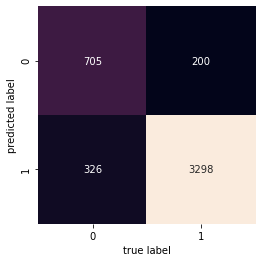

<ipython-input-10-d3da9126ecf1>:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


Area Under Curve: 0.95


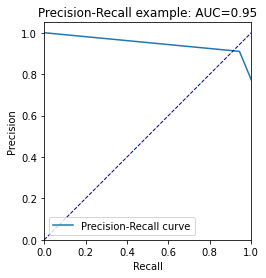

<ipython-input-10-d3da9126ecf1>:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


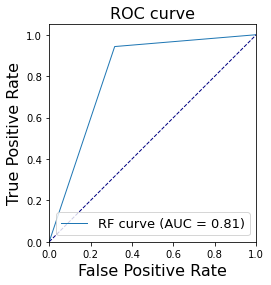

(array([[ 705,  326],
        [ 200, 3298]], dtype=int64),
 '              precision    recall  f1-score   support\n\n           0       0.78      0.68      0.73      1031\n           1       0.91      0.94      0.93      3498\n\n    accuracy                           0.88      4529\n   macro avg       0.84      0.81      0.83      4529\nweighted avg       0.88      0.88      0.88      4529\n')

In [24]:
LogisticRegression_binary_classification(w2vX_train, w2vy_train, w2vX_test, w2vy_test)

In [ ]:
Decision_Tree_binary_classification_Tuned(w2vX_train, w2vy_train, w2vX_test, w2vy_test)

In [ ]:
XgBoost_binary_classification_Tuned(w2vX_train, w2vy_train, w2vX_test, w2vy_test)

## Reprsentation 

In [15]:
similar_words = {search_term: [item[0] for item in model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['love', 'top', 'dress', 'hate', 'color', 'winter', 'most','wear']}
similar_words

{'love': ['beautiful', 'adore', 'gorgeous', 'amazing', 'cute'],
 'top': ['blouse', 'shirt', 'tank', 'peplum', 'cami'],
 'dress': ['wedding', 'slip', 'occasion', 'jumpsuit', 'shift'],
 'hate': ['currently', 'people', 'strange', 'wrinkly', 'relaxed'],
 'color': ['shade', 'blue', 'red', 'print', 'grey'],
 'winter': ['summer', 'weather', 'bootie', 'season', 'sweater'],
 'most': ['many', 'other', 'normally', 'usually', 'favorite'],
 'wear': ['get', 'throw', 'layer', 'rock', 'use']}

In [ ]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [16]:
unique_words = list(set([word for sublist in [doc.split() for doc in df['Review Text Precrocessed']] for word in sublist]))

In [17]:
len(unique_words)

11493

In [18]:
unique_words[:-10]

['prisoner',
 'attention',
 'hindsight',
 'skinnys',
 'measument',
 'bedelia',
 'monogram',
 'pig',
 'ia',
 'bustline',
 'favorite',
 'lineman',
 'zone',
 'zigzag',
 'amsterdam',
 'wynwood',
 'nike',
 'myriad',
 'ashley',
 'portray',
 'safari',
 'rt',
 'live',
 'tmie',
 'secondhand',
 'drappy',
 'nat',
 'cream',
 'ands',
 'sage',
 'sunset',
 'tig',
 'sloppy',
 'god',
 'naomi',
 'sabrina',
 'bout',
 'barney',
 'cheste',
 'brught',
 'wee',
 'impeccable',
 'freezer',
 'consolation',
 'intricately',
 'generaly',
 'town',
 'preferred',
 '180',
 'flea',
 'shearliing',
 'jessica',
 'smack',
 'stitch',
 'mesmerize',
 'inconsistent',
 '17',
 'reverse',
 'tiger',
 'spare',
 'pry',
 'imlove',
 'busy',
 'overhang',
 'remove',
 'delaney',
 'junior',
 '128',
 'browns',
 'hose',
 'deodorant',
 'pintuck',
 'norm',
 'resist',
 'madra',
 'asser',
 'loosly',
 'pantyhose',
 'cutter',
 'game',
 'strecthy',
 'duller',
 'baby',
 'uncle',
 'enjoy',
 'loungin',
 'torsoed',
 '1st',
 'gaping',
 'slimming',
 'fun

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0)
pcs = pca.fit_transform(X)
labels = unique_words[:-10]
categories = list(df['Label'])
plt.figure(figsize=(8, 6))

for i in range(len(labels)):
    label = labels[i]
    color = 'orange' if label == 0 else 'blue' if label == 1 else 'green'
    annotation_label = categories[i]
    x, y = pcs[i]
    plt.scatter(x, y, c=color, edgecolors='k')
    plt.annotate(annotation_label, xy=(x+1e-4, y+1e-3), xytext=(0, 0), textcoords='offset points')


# GloVe Embeddings

## Using pretrained word vectors using StanFord

In [ ]:
import numpy as np

In [ ]:
glove_vectors = dict()

In [ ]:
%%time

file = open('C:/Users/anagha.bhople/Desktop/Sentiment Analysis/GloVe Word Embedding/glove/glove.6B.100d.txt', encoding='utf-8')

for line in file:
    values = line.split()
    
    word  = values[0]
    vectors = np.asarray(values[1:])
    glove_vectors[word] = vectors
    
file.close()

In [ ]:
glove_vectors

In [ ]:
len(glove_vectors)

In [ ]:
glove_vectors.get('jacket')

In [ ]:
x = 'hi hello'
vec_shape = 100

In [ ]:
def get_vec(x):
    arr = np.zeros(vec_shape)
    text = str(x).split()
    
    for t in text:
        try:
            vec = glove_vectors.get(t).astype(float)
            arr = arr + vec
        except:
            pass
        
    arr = arr.reshape(1, -1)[0]
    return arr/len(text)

In [ ]:
get_vec(x)

In [ ]:
get_vec('hello hi how are you').shape

In [ ]:
df['Review Text Precrocessed'].iloc[92]=df['Review Text Precrocessed'].iloc[100]

In [ ]:
df['Review Text Precrocessed'].iloc[92]

In [ ]:
%%time
df['Review Vector Golve']=df['Review Text Precrocessed'].apply(lambda x: get_vec(x))

In [ ]:
df['Review Vector Golve'].iloc[92]

In [ ]:
X_glo = df['Review Vector Golve']
Y_glo = df['Label']

In [ ]:
X_glo.iloc[93]

In [ ]:
X_glo = np.concatenate(X_glo, axis = 0).reshape(-1, vec_shape)

In [ ]:
X_glo.shape, Y_glo.shape

In [ ]:
w2v_Y=df['Label']
w2v_X=X
w2vX_train, w2vX_test, w2vy_train, w2vy_test = train_test_split(w2v_X,w2v_Y, test_size=.20, random_state=101)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

In [ ]:
X_train.shape, X_test.shape

# Using Spacy

In [ ]:
## https://towardsdatascience.com/understanding-feature-engineering-part-4-deep-learning-methods-for-text-data-96c44370bbfa
## https://towardsdatascience.com/light-on-math-ml-intuitive-guide-to-understanding-glove-embeddings-b13b4f19c010

In [ ]:
## pip install -U spacy --user

In [19]:
import spacy
import en_core_web_lg
nlp_glove = en_core_web_lg.load()

total_vectors = len(nlp_glove.vocab.vectors)
print('Total word vectors:', total_vectors)

Total word vectors: 684831


In [20]:
print("yes")

yes


In [21]:
doc_glove_vectors = np.array([nlp_glove(str(doc)).vector for doc in df['Review Text Precrocessed']])

In [28]:
doc_glove_vectors.shape

(22642, 300)

In [24]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=2, random_state=0)
km.fit_transform(doc_glove_vectors)
cluster_labels = km.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([df, cluster_labels], axis=1)

,index,Review Text,Rating,Recommended IND,Positive Feedback Count,Review Text Precrocessed,Char_Count,Word_Count,Label,Label_3C,Review Text w2v,doc_vector,ClusterLabel
0,0.0,Absolutely wonderful - silky and sexy and comf...,4.0,1.0,0.0,absolutely wonderful silky and sexy and comfor...,171.0,8.0,1.0,1.0,"[absolutely, wonderful, silky, and, sexy, and,...","[0.6667356, 0.23074262, -2.0515187, 0.23169217...",1.0
1,1.0,Love this dress! it's sooo pretty. i happene...,5.0,1.0,4.0,love this dress -PRON- is sooo pretty i happen...,1095.0,62.0,1.0,1.0,"[love, this, dress, PRON, is, sooo, pretty, i,...","[-0.07581062, 0.34023374, -0.2936284, 0.148150...",0.0
2,2.0,I had such high hopes for this dress and reall...,3.0,0.0,0.0,i have such high hope for this dress and reall...,1785.0,98.0,0.0,2.0,"[i, have, such, high, hope, for, this, dress, ...","[0.16383666, -0.27136472, 0.35035923, 0.174896...",0.0
3,3.0,"I love, love, love this jumpsuit. it's fun, fl...",5.0,1.0,0.0,i love love love this jumpsuit -PRON- is fun f...,425.0,22.0,1.0,1.0,"[i, love, love, love, this, jumpsuit, PRON, is...","[0.045769278, -0.55828094, 0.09166749, -0.5709...",1.0
4,4.0,This shirt is very flattering to all due to th...,5.0,1.0,6.0,this shirt is very flattering to all due to th...,673.0,36.0,1.0,1.0,"[this, shirt, is, very, flattering, to, all, d...","[-0.67256707, -0.11260927, -0.24647212, 0.2660...",1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23481,23481.0,I was very happy to snag this dress at such a ...,5.0,1.0,0.0,i was very happy to snag this dress at such a ...,487.0,28.0,1.0,1.0,"[i, was, very, happy, to, snag, this, dress, a...","[0.054669604, -0.00069097814, -0.17360154, 0.2...",NaN
23482,23482.0,"It reminds me of maternity clothes. soft, stre...",3.0,1.0,0.0,-PRON- remind -PRON- of maternity clothe soft ...,751.0,37.0,0.0,2.0,"[PRON, remind, PRON, of, maternity, clothe, so...","[0.6388619, 0.15517102, -0.008465272, 0.212260...",NaN
23483,23483.0,"This fit well, but the top was very see throug...",3.0,0.0,1.0,this fit well but the top was very see through...,753.0,42.0,0.0,2.0,"[this, fit, well, but, the, top, was, very, se...","[-0.078801565, 0.0872148, 0.21623492, 0.578276...",NaN
23484,23484.0,I bought this dress for a wedding i have this ...,3.0,1.0,2.0,i buy this dress for a wedding i have this sum...,1543.0,86.0,0.0,2.0,"[i, buy, this, dress, for, a, wedding, i, have...","[0.16037644, -0.10358044, 0.35796753, 0.480930...",NaN


In [26]:
word_glove_vectors = np.array([nlp(word).vector for word in unique_words])
pd.DataFrame(word_glove_vectors, index=unique_words)

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
prisoner,2.444096,-1.048554,0.338357,-1.117354,3.071404,0.099220,-0.168320,1.436996,-2.382604,1.898998,...,-0.996905,-0.528750,-1.223418,-2.071856,-1.269976,0.819373,-0.734459,-1.417824,1.669450,-2.791025
attention,0.433983,0.529620,-0.372036,-1.879126,0.403160,-1.539560,0.927204,0.916059,-2.876764,3.389391,...,1.344416,-0.548986,-0.686549,-0.638004,-1.403282,-0.306960,-0.011412,-0.590305,3.711290,-1.305033
hindsight,-0.127167,-1.730329,0.198881,-1.310831,0.027345,2.771600,1.507778,0.052187,-1.959684,1.295352,...,1.554513,-1.290472,-0.692016,-1.240656,-2.840114,0.344567,-0.370998,-0.653507,-0.911530,-3.298528
skinnys,2.635917,-0.445141,-0.980697,-1.594449,1.238068,-0.155139,0.340080,0.768545,-0.811695,0.869766,...,-2.069973,-0.382748,1.848460,-1.406814,-1.650574,0.982188,0.914445,0.481658,-1.010581,-2.134973
measument,2.513573,-0.853096,1.354463,-0.408388,3.080438,-2.280826,1.068074,3.230855,-1.020792,0.950181,...,0.563004,1.272085,0.697535,-1.806478,-1.234997,2.324682,1.329247,0.741522,-2.354919,-0.715951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cooperate,-0.962485,1.265012,1.443665,-2.212085,1.116650,0.187263,-0.234940,-1.356185,-3.535732,0.700258,...,0.002114,-0.652980,1.992082,-0.755697,-2.502037,0.428548,1.737690,-1.132909,-0.768099,-3.027782
ipad,-1.199534,0.406725,4.306109,-0.779370,0.273508,0.059175,1.110045,0.675611,-3.633495,2.751417,...,-0.611589,-1.073274,-0.998800,-1.890251,-2.527622,2.471528,0.033805,-0.491193,-1.193174,-2.721292
drama,-0.231569,0.507272,2.171112,-0.291571,0.911351,-1.533784,1.338455,-1.053177,-2.797178,3.652400,...,-1.105030,0.722793,0.291764,-0.814338,-5.990744,2.748205,-0.529849,2.176311,-0.156518,-2.615210
spor,-2.251201,-1.921657,0.811149,-1.549014,0.065768,0.600400,1.465902,4.977974,-0.957726,5.834974,...,1.987449,-0.871976,-1.355309,-0.672301,-2.012983,1.454068,1.498613,-0.039511,-3.119975,-1.297409


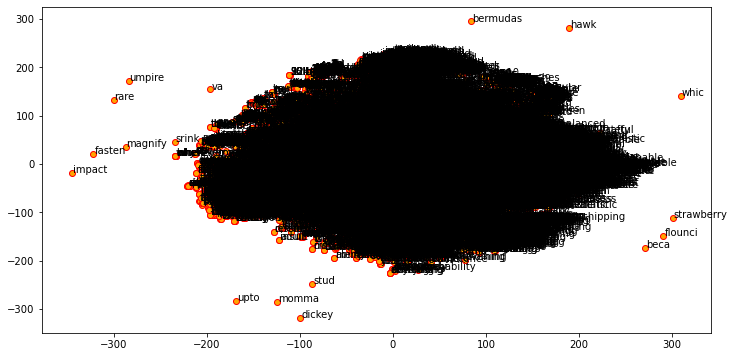

In [27]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_glove_vectors)
labels = unique_words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [29]:
g_Y=df['Label']
g_X=doc_glove_vectors
gX_train, gy_train, gX_test, gy_test = train_test_split(g_X, g_Y, test_size=.20, random_state=101)

In [41]:
g_Y.shape 

(22642,)

In [42]:
g_X.shape

(22642, 300)

[[ 565  466]
 [ 169 3329]]
              precision    recall  f1-score   support

           0       0.77      0.55      0.64      1031
           1       0.88      0.95      0.91      3498

    accuracy                           0.86      4529
   macro avg       0.82      0.75      0.78      4529
weighted avg       0.85      0.86      0.85      4529

Accuracy Score: 0.8597924486641643
F1 Score: 0.9129302070478541
Average precision-recall score: 0.8721411547421507


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


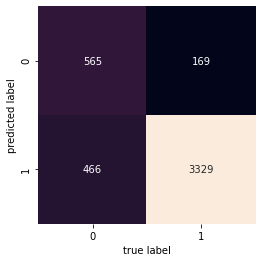

<ipython-input-34-d3da9126ecf1>:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


Area Under Curve: 0.93


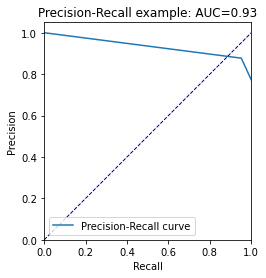

<ipython-input-34-d3da9126ecf1>:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


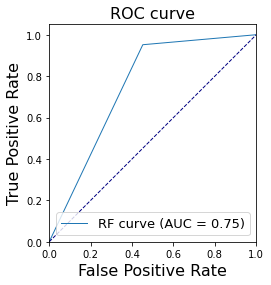

(array([[ 565,  466],
        [ 169, 3329]], dtype=int64),
 '              precision    recall  f1-score   support\n\n           0       0.77      0.55      0.64      1031\n           1       0.88      0.95      0.91      3498\n\n    accuracy                           0.86      4529\n   macro avg       0.82      0.75      0.78      4529\nweighted avg       0.85      0.86      0.85      4529\n')

In [43]:
LogisticRegression_binary_classification(gX_train, gy_train, gX_test, gy_test)

# Testing

In [ ]:
## Positive Review Testing

In [ ]:
val=random.choice(Positives)
Test_sentence = df.loc[ (df['Label'] == 1) & (df['index'] == val) , 'Review Text']

In [ ]:
## Negative Review Testing

In [ ]:
val=random.choice(Negatives)
Test_sentence = df.loc[ (df['Label'] == 0) & (df['index'] == val) , 'Review Text']

In [ ]:
## Test Your Own Sentence

In [ ]:
Test_sentence =["This dress is very good but color is bad"]

In [ ]:
## Test According to Customer ID

In [ ]:
Test_sentence = df.loc[df['index'] == 10 , 'Review Text']

In [ ]:
Test_sentence

In [ ]:
pd.set_option('display.max_colwidth', 1000)
print("Original Review")
print(Test_sentence)
print("\n")


print("Actual Label")
Actual_label= df.loc[df['index'] == val , 'Label']
print(Actual_label)
print("\n")

def prediction(x):
    x=df.loc[df['index'] == val , 'Review Text Precrocessed']
    X=tfidf.transform(x)
    pred=clf.predict(X)
    if pred==0:
      return 'Negative'
    else:
      return 'Positive'

prediction(Test_sentence)